In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
q = 1.6e-19       # Elementary charge (Coulombs)
m = 9.1e-31*1836  # Proton mass (kg)
c = 3.0e8         # Speed of light (m/s)

In [3]:
# Initial conditions, 3D (x, y, z) + 3V (vx, vy, vz) + E & B fields + gyro period
def init_gyro(vx0, Bz0):
    """
    function for initialization of a simple gyration case
    input:
        vx0: float, velocity along x-direction, in m/s
        Bz0: float, magnetic field along z-direction, in T
    output:
        initial_position: array of float, [x, y, z] at t0, in m
        initial_velocity: array of float, [vx, vy, vz] at t0, in m/s
        electric_field:   array of float, [Ex, Ey, Ez] as a function of position [x, y, z] only, in V/m
        magnetic_field:   array of float, [Bx, By, Bz] as a function of position [x, y, z] only, in T
        tau_c:            float, the gyro period, i.e., $2\pi m / (qB)$, in s 
    """
    
    initial_position = np.array([0.0, 0.0, 0.0])  # Initial position (meters)
    initial_velocity = np.array([vx0 , 0.0, 0.0])  # Initial velocity (m/s), vx = 100 km/s

    # physical constrain on the velocities
    print("Note that your velocity vx0 = {:.1e} m/s should be much smaller than the speed of light c = {:.1e} m/s".format(vx0, c))
    print("since we are here demonstrating within the non-relativistic regime.")
    print("For the fully relativistic one, please refer to: ")
    print("J. P. Boris, Proc. Fourth Conf. Num. Sim. Plasmas 3-67 (1970) ")
    print(" ")

    # Electric and magnetic fields
    def electric_field(position):
        """
        function for a static electric field
        input:
            position: array of float, [x, y, z], in m
        output:
            zero every where
        """
        return np.array([0.0, 0.0, 0.0])  # No electric field

    def magnetic_field(position):
        """
        function for a static magnetic field
        input:
            position: array of float, [x, y, z], in m
        output:
            only along the z-direction with the value of Bz0, in T
        """
        return np.array([0.0, 0.0, Bz0]) 

    tau_c = 2.0 * np.pi * m / (q * Bz0) # gyro period (s)
    print("Also note that the timestep should be much smaller than tau_c = {:.1e} s".format(tau_c)) 
    print(" ")
    
    return initial_position, initial_velocity, electric_field, magnetic_field, tau_c

## Boris Pusher Algorithm

<div>
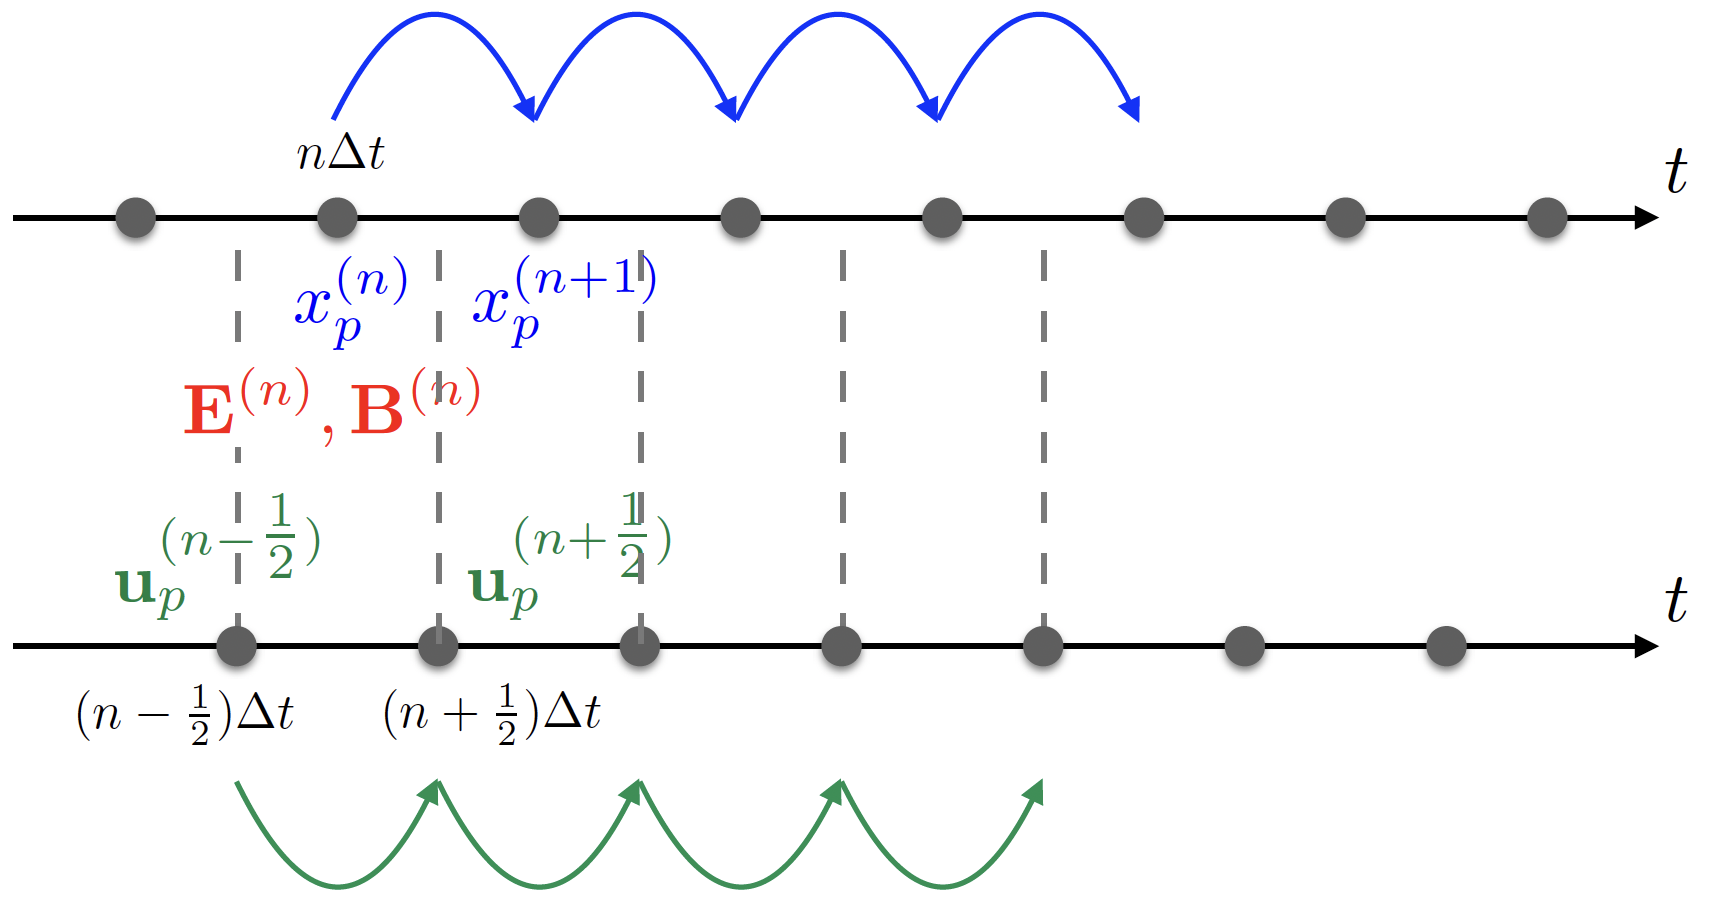
</div>

#### note that:
    1. the velocities are defined at half     time-steps t^{n+1/2}
    2. the positions  are defined at integral time-steps t^{n}
    3. here we limited ourselves within the non-relativistic regime, i.e., gamma = 1

In [ ]:
def boris_pusher(dt, t_max):
    """
    function that pushes the charged particle through Lorentz force under given EM fields
    input:
        dt:    float, timestep in s
        t_max: float, total simulation time in s
    output:
        positions:      array of floats, (t,[x,y,z]), in m
        velocities:     array of floats, (t,[vx,vy,vz]), in m/s
        kinetic_energy: array of floats, (t,energy), in eV
    """
    # Initialize arrays to store data
    num_steps = int(t_max / dt)
    positions = np.zeros((num_steps, 3))
    velocities = np.zeros((num_steps, 3))
    
    # Apply initial conditions to the arrays
    positions[0] = initial_position
    velocities[0] = initial_velocity

    # The boris pusher
    for i in range(1, num_steps):
        # useful coefficient: \frac{q dt}{2 m}
        coef = q / m * dt * 0.5

        # Step 1: u^{-} = u^{n-1/2} + coef * E^n
        u_minus = velocities[i-1] + coef * electric_field(positions[i])

        # t = -coef * B^n
        t = -1.0 * coef * magnetic_field(positions[i])

        # Step 2: u' = u^{-} + u^{-} \times t
        u_prime = u_minus + np.cross(u_minus, t)

        # s = \frac{2t}{1+t^2}
        s = 2.0 * t / (1.0 + t**2)

        # Step 3: u^{+} = u^{-} + u^{-} \times s
        u_plus = u_minus + np.cross(u_minus, s)

        # Step 4: u^{n+1/2} = u^{+} + coef * E^n
        velocities[i] = u_plus + coef * electric_field(positions[i])

        # update the new positions with r^{n} = r^{n-1} + u^{n+1/2} * dt
        positions[i] = positions[i-1] + velocities[i] * dt
        
    # energy conservation check
    kinetic_energy = np.zeros((num_steps, 1))
    kinetic_energy[:,0] = 0.5 * m * (velocities[:,0]**2 + velocities[:,1]**2 + velocities[:,2]**2) / q # in eV

    # physical constrain on the dt
    print("Attention:")
    print("your timestep dt = {:.1e} s".format(dt))
    print("vs")
    print("the gyro period tau_c = {:.1e} s".format(tau_c))
    return positions, velocities, kinetic_energy

In [5]:
# Have a test run:

vx0 = 1e4  # initial velocity along x-direction (m/s)
Bz0 = 1.0  # Magnetic field strength (Tesla)
initial_position, initial_velocity, electric_field, magnetic_field, tau_c = init_gyro(vx0, Bz0)

dt = 1e-12  # Timestep (s)
t_max = 1e-7  # Total simulation time (s)
positions, velocities, kinetic_energy = boris_pusher(dt, t_max)

# try this:
# positions, velocities, kinetic_energy = boris_pusher(1e-12, 1e-8)

Note that your velocity vx0 = 1.0e+04 m/s should be much smaller than the speed of light c = 3.0e+08 m/s
since we are here demonstrating within the non-relativistic regime.
For the fully relativistic one, please refer to: 
J. P. Boris, Proc. Fourth Conf. Num. Sim. Plasmas 3-67 (1970) 
 
Also note that the timestep should be much smaller than tau_c = 6.6e-08 s
 
Attention:
your timestep dt = 1.0e-12 s
vs
the gyro period tau_c = 6.6e-08 s


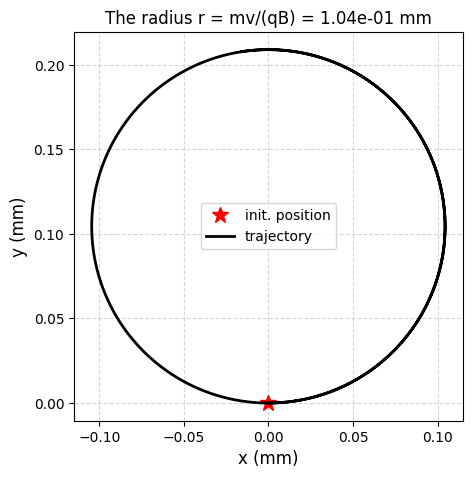

In [7]:
# Plot the particle trajectory

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)


ax.plot(positions[0, 0]*1e3, positions[0, 1]*1e3, 
        '*r', 
        markersize=12,
        label='init. position',
       )


ax.plot(positions[:, 0]*1e3, positions[:, 1]*1e3, 
        color='k', 
        ls='solid', 
        lw=2.0,
        label='trajectory'
       )

ax.set_xlabel('x (mm)',fontsize=12)
ax.set_ylabel('y (mm)',fontsize=12)
ax.set_aspect('equal')
ax.set_title('The radius r = mv/(qB) = {:.2e} mm'.format(m*vx0/q/Bz0*1e3))
ax.legend()
ax.grid(ls='--',alpha=0.5)

plt.show()


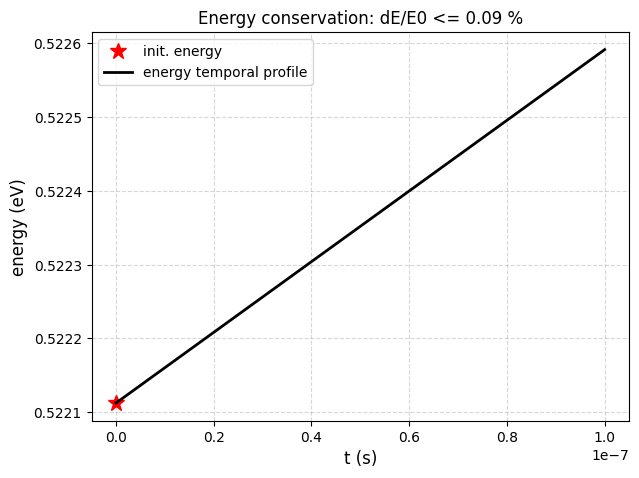

In [9]:
# Plot the particle energy temporal evolution

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

time = np.linspace(0,t_max,int(t_max/dt))

ax.plot(time[0], kinetic_energy[0, 0], 
        '*r', 
        markersize=12,
        label='init. energy',
       )

ax.plot(time[:], kinetic_energy[:, 0], 
        color='k', 
        ls='solid', 
        lw=2.0,
        label='energy temporal profile'
       )

ax.set_xlabel('t (s)',fontsize=12)
ax.set_ylabel('energy (eV)',fontsize=12)

ax.set_title('Energy conservation: dE/E0 <= {:.2f} %'.format((kinetic_energy[-1,0]-kinetic_energy[0,0])/kinetic_energy[0,0]*100))
ax.legend()
ax.grid(ls='--',alpha=0.5)

plt.show()


In [10]:
# Initial conditions, 3D (x, y, z) + 3V (vx, vy, vz) + E & B fields + gyro period
def init_drift(vx0, Ex0, Bz0):
    """
    function for initialization of a simple gyration case
    input:
        vx0: float, velocity along x-direction, in m/s
        Bz0: float, magnetic field along z-direction, in T
    output:
        initial_position: array of float, [x, y, z] at t0, in m
        initial_velocity: array of float, [vx, vy, vz] at t0, in m/s
        electric_field:   array of float, [Ex, Ey, Ez] as a function of position [x, y, z] only, in V/m
        magnetic_field:   array of float, [Bx, By, Bz] as a function of position [x, y, z] only, in T
        tau_c:            float, the gyro period, i.e., $2\pi m / (qB)$, in s 
    """
    
    initial_position = np.array([0.0, 0.0, 0.0])  # Initial position (meters)
    initial_velocity = np.array([vx0 , 0.0, 0.0])  # Initial velocity (m/s), vx = 100 km/s

    # physical constrain on the velocities
    print("Note that your velocity vx0 = {:.1e} m/s should be much smaller than the speed of light c = {:.1e} m/s".format(vx0, c))
    print("since we are here demonstrating within the non-relativistic regime.")
    print("For the fully relativistic one, please refer to: ")
    print("J. P. Boris, Proc. Fourth Conf. Num. Sim. Plasmas 3-67 (1970) ")
    print(" ")

    # Electric and magnetic fields
    def electric_field(position):
        """
        function for a static electric field
        input:
            position: array of float, [x, y, z], in m
        output:
            only along the x-direction with the value of Ex0, in V/m
        """
        return np.array([Ex0, 0.0, 0.0])

    def magnetic_field(position):
        """
        function for a static magnetic field
        input:
            position: array of float, [x, y, z], in m
        output:
            only along the z-direction with the value of Bz0, in T
        """
        return np.array([0.0, 0.0, Bz0]) 

    tau_c = 2.0 * np.pi * m / (q * Bz0) # gyro period (s)
    print("Also note that the timestep should be much smaller than tau_c = {:.1e} s".format(tau_c)) 
    print(" ")
    
    return initial_position, initial_velocity, electric_field, magnetic_field, tau_c

In [11]:
Ex0 = 1e3  # V/m
initial_position, initial_velocity, electric_field, magnetic_field, tau_c = init_drift(vx0, Ex0, Bz0)

positions, velocities, kinetic_energy = boris_pusher(1e-12, 2e-7)

Note that your velocity vx0 = 1.0e+04 m/s should be much smaller than the speed of light c = 3.0e+08 m/s
since we are here demonstrating within the non-relativistic regime.
For the fully relativistic one, please refer to: 
J. P. Boris, Proc. Fourth Conf. Num. Sim. Plasmas 3-67 (1970) 
 
Also note that the timestep should be much smaller than tau_c = 6.6e-08 s
 
Attention:
your timestep dt = 1.0e-12 s
vs
the gyro period tau_c = 6.6e-08 s


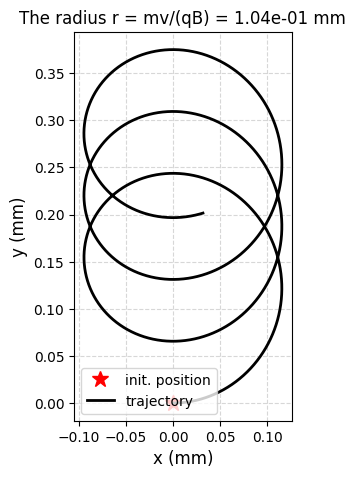

In [13]:
# Plot the particle trajectory

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

ax.plot(positions[0, 0]*1e3, positions[0, 1]*1e3, 
        '*r', 
        markersize=12,
        label='init. position',
       )
ax.plot(positions[:, 0]*1e3, positions[:, 1]*1e3, 
        color='k', 
        ls='solid', 
        lw=2.0,
        label='trajectory'
       )

ax.set_xlabel('x (mm)',fontsize=12)
ax.set_ylabel('y (mm)',fontsize=12)
ax.set_aspect('equal')
ax.set_title('The radius r = mv/(qB) = {:.2e} mm'.format(m*vx0/q/Bz0*1e3))
ax.legend()
ax.grid(ls='--',alpha=0.5)

plt.show()

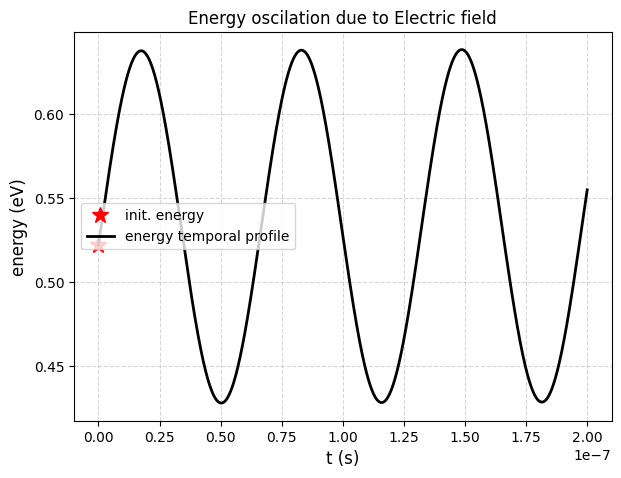

In [31]:
# Plot the particle energy temporal evolution

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

time = np.linspace(0,2e-7,int(2e-7/1e-12))

ax.plot(time[0], kinetic_energy[0, 0], 
        '*r', 
        markersize=12,
        label='init. energy',
       )

ax.plot(time[:], kinetic_energy[:, 0], 
        color='k', 
        ls='solid', 
        lw=2.0,
        label='energy temporal profile'
       )

ax.set_xlabel('t (s)',fontsize=12)
ax.set_ylabel('energy (eV)',fontsize=12)


# up = (kinetic_energy.max()-kinetic_energy[0,0])/kinetic_energy[0,0]*100
# down = (kinetic_energy[0,0]-kinetic_energy.min())/kinetic_energy[0,0]*100
# ax.set_title('Energy conservation: dE/E0 <= {:.2f} %'.format(np.maximum(up, down)))

ax.set_title('Energy oscilation due to Electric field')

ax.legend()
ax.grid(ls='--',alpha=0.5)

plt.show()


### More exercises:

- normalize this
- implement the Boris pusher in the fully relativistic regime
- try spatially non-homogeneous EM fields structures
- the EM wave propagation


## EM wave propagation via FDTD 

<div>
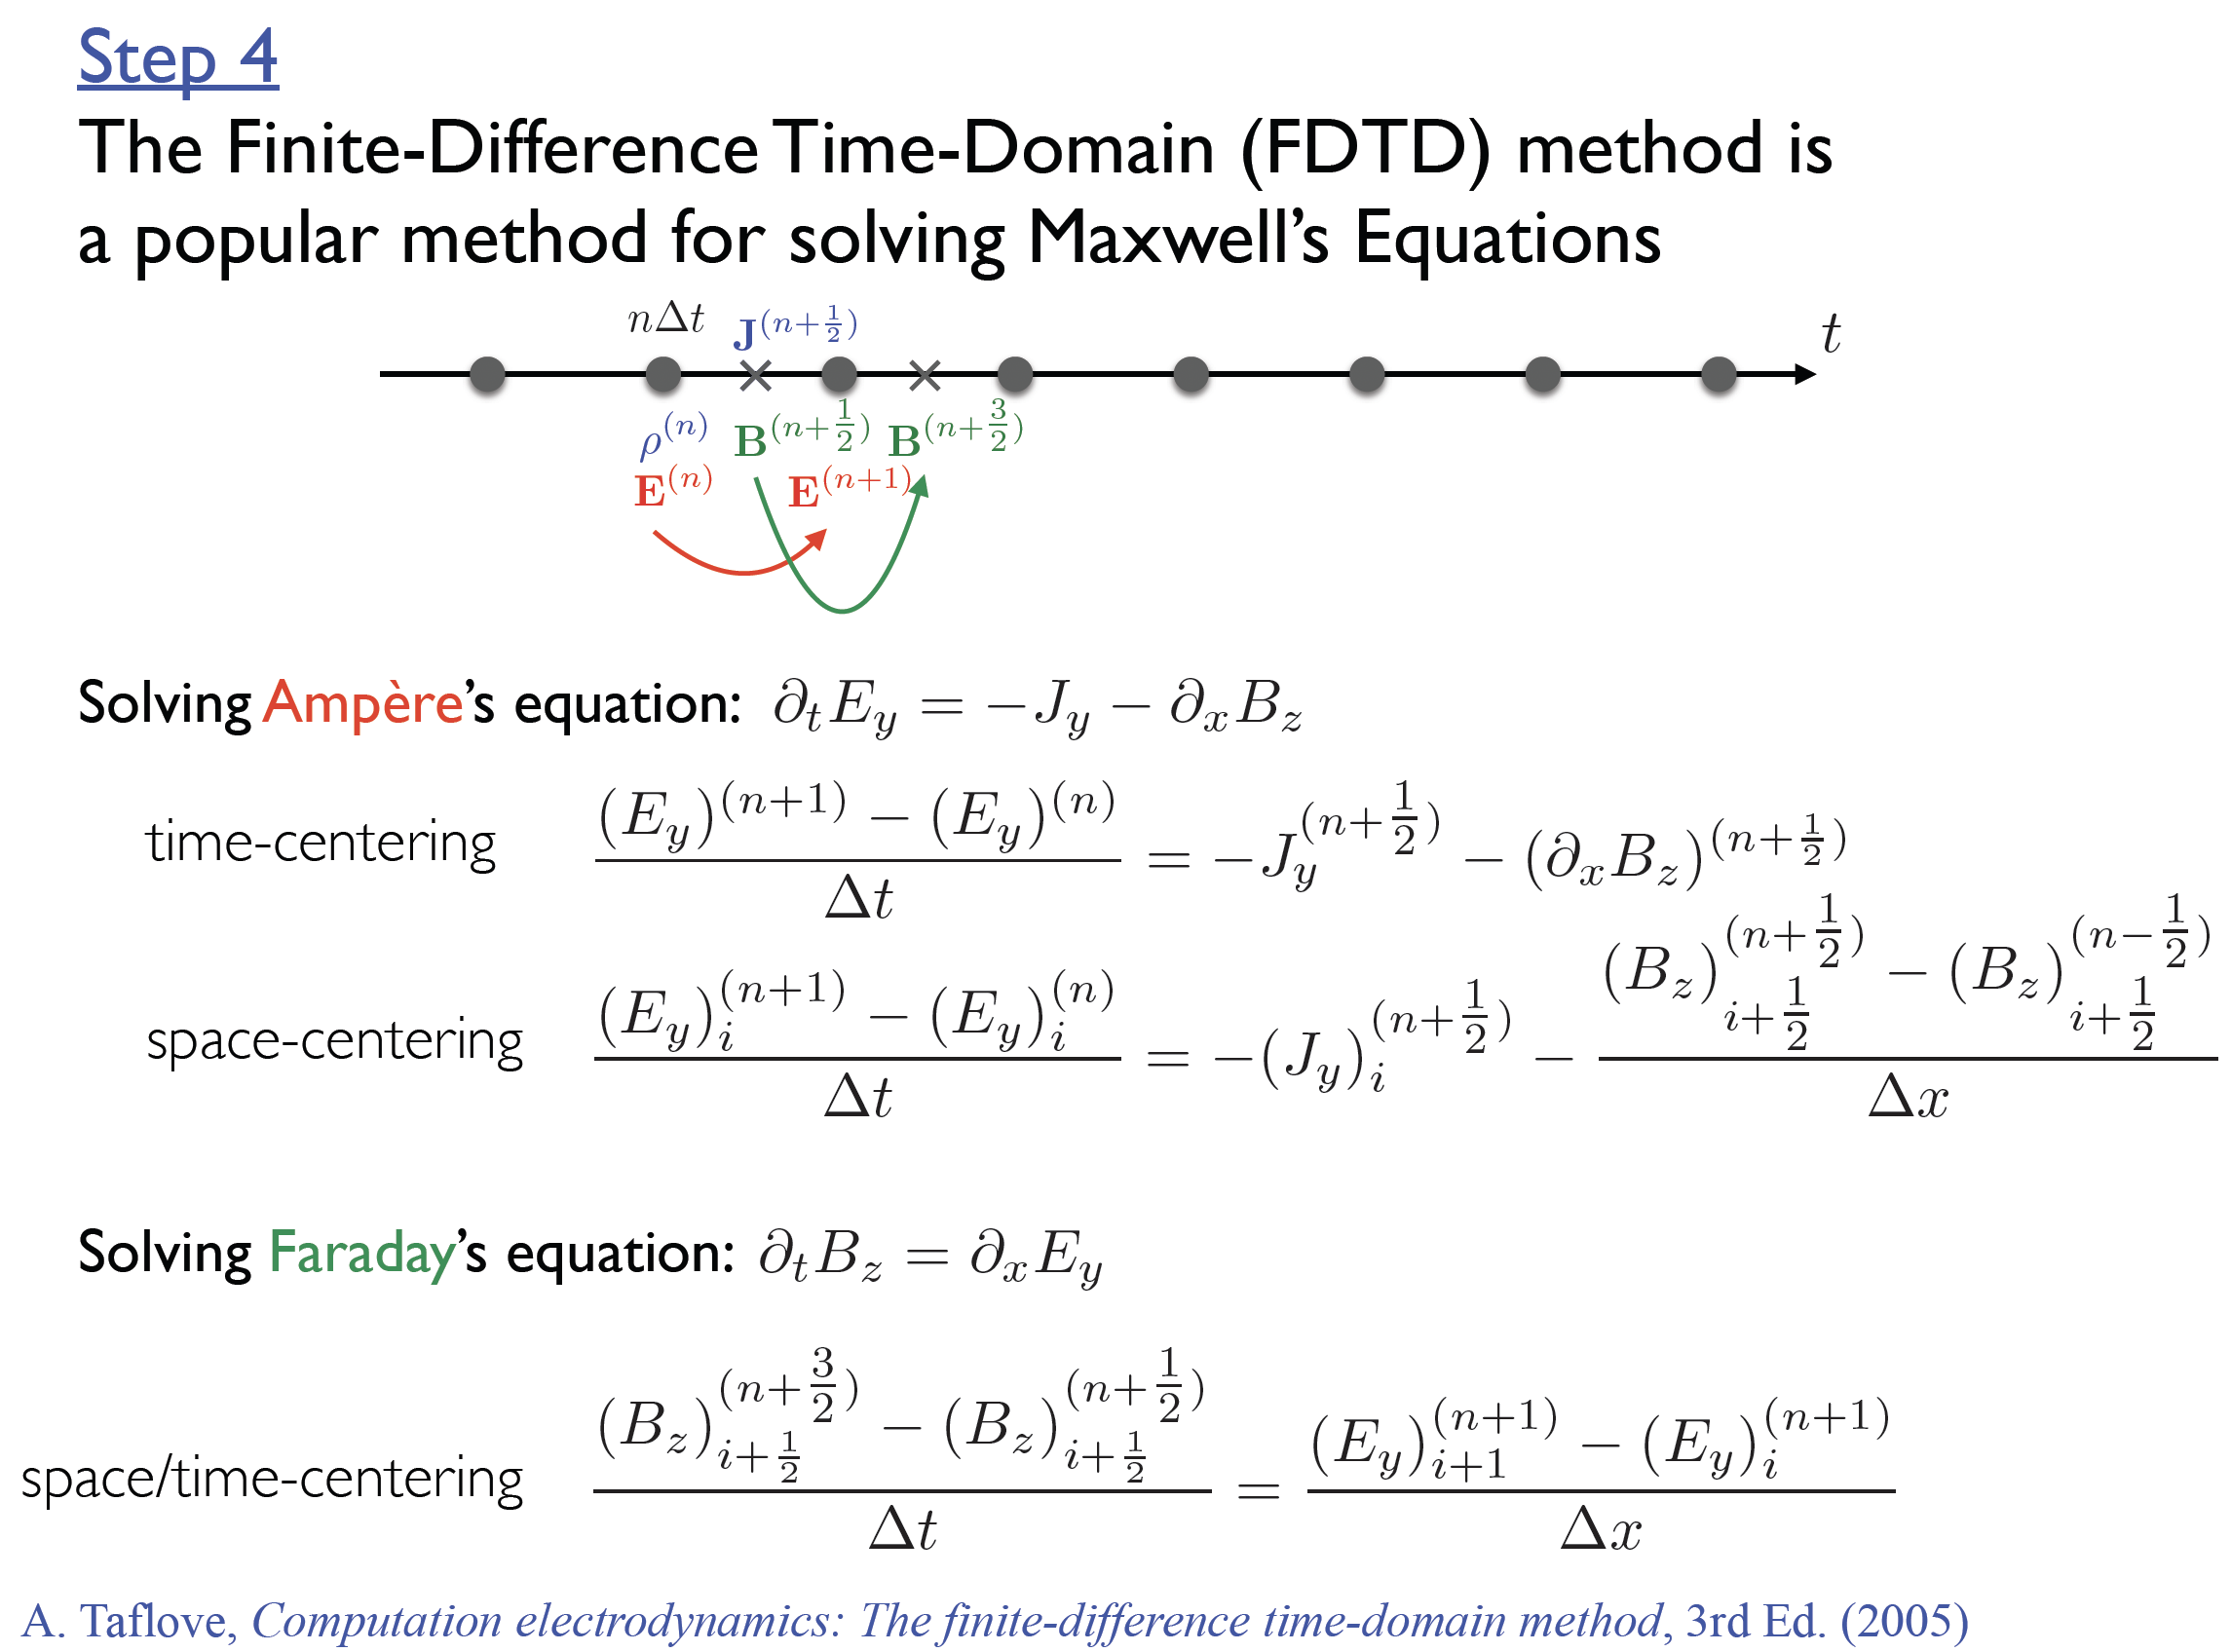
</div>

#### note:
1. Yee mesh
<div>
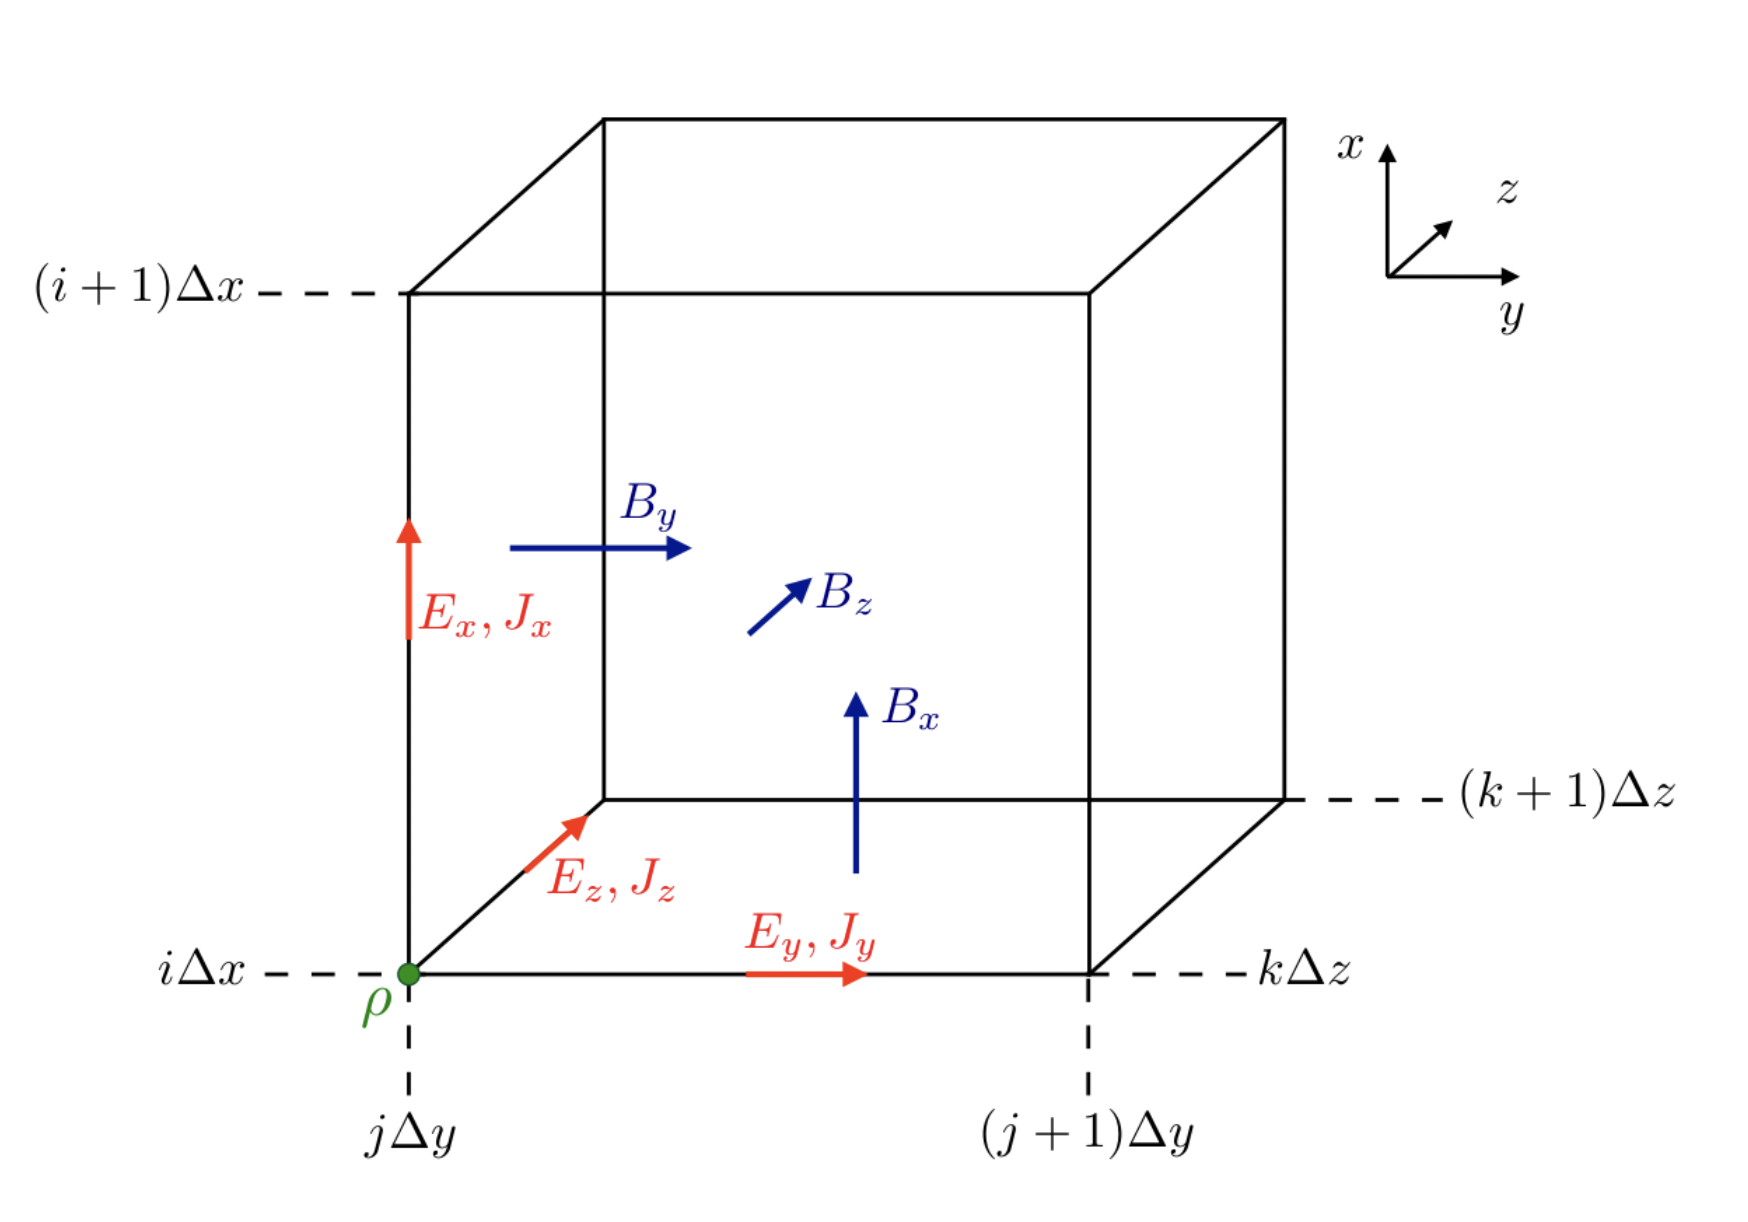
</div>
3. boundary conditions
4. source
5. vectorize, instead of for-loops

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

c = 1 # normalized

jmax = 500  # space
jsource = 10 # 
nmax = 2000 # time 


Ey = np.zeros(jmax)
Bz = np.zeros(jmax)
Ey_prev = np.zeros(jmax)
Bz_prev = np.zeros(jmax)

dx = 0.1 
dt = dx/c

def source(t):
    tau = 30
    t0  = tau*3
    lm0 = 1.0  # normalized
    w0  = 2.0 * np.pi * c / lm0
    return np.exp(-(t-t0)**2/tau**2) * np.sin(w0*t*dt)



# from 0 to nmax
for n in range(nmax):
    # BC for Bz: Bz(jmax,n) = Bz(jmax-1,n-1); try to turn it off and check
    Bz[jmax-1] = Bz_prev[jmax-2]
    # # update B from 0 to jmax-1
    # for j in range(jmax-1):
    #     Bz[j] = Bz_prev[j] + dt/dx * (Ey[j+1] - Ey[j])
    #     Bz_prev[j] = Bz[j]
    # vectorize
    Bz[:jmax-1] = Bz_prev[:jmax-1] + dt/dx * (Ey[1:jmax] - Ey[:jmax-1])
    Bz_prev = Bz
    # add B source; try to turn if off and leave only the E source
    Bz[jsource-1] -= source(n)
    Bz_prev[jsource-1] = Bz[jsource-1]
    

    # BC for Ey: Ey(0,n) = Ey(1,n-1); try to turn it off and check
    Ey[0] = Ey_prev[1]
    # # update E from 1 to jmax
    # for j in range(1,jmax):
    #     Ey[j] = Ey_prev[j] + dt/dx * (Bz[j] - Bz[j-1])
    #     Ey_prev[j] = Ey[j]
    # vectorize
    Ey[1:] = Ey_prev[1:] + dt/dx * (Bz[1:] - Bz[:jmax-1])
    Ey_prev = Ey
    # add E source
    Ey[jsource] += source(n+1)
    Ey_prev[jsource] = Ey[jsource]

    if n%10 == 0:
        plt.plot(Ey)
        plt.ylim(-1,1)
        plt.show()
        plt.close()
    

### play with 'plasma'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

c = 1 # normalized
mu0 = 1
eps0 = 1

eps = np.ones(jmax)
eps[225:275] = 10*eps0
plasma = eps > eps0

jmax = 500  # space
jsource = 10 # 
nmax = 2000 # time 


Ey = np.zeros(jmax)
Bz = np.zeros(jmax)
Ey_prev = np.zeros(jmax)
Bz_prev = np.zeros(jmax)

dx = 0.1 
dt = dx/c

def source(t):
    tau = 30
    t0  = tau*3
    lm0 = 1.0  # normalized
    w0  = 2.0 * np.pi * c / lm0
    return np.exp(-(t-t0)**2/tau**2) * np.sin(w0*t*dt)

# from 0 to nmax
for n in range(nmax):
    # BC for Bz: Bz(jmax,n) = Bz(jmax-1,n-1); try to turn it off and check
    Bz[jmax-1] = Bz_prev[jmax-2]
    # update B from 0 to jmax-1
    for j in range(jmax-1):
        Bz[j] = Bz_prev[j] + dt/(dx*mu0) * (Ey[j+1] - Ey[j])
        Bz_prev[j] = Bz[j]
    # add B source; try to turn if off and leave only the E source
    Bz[jsource-1] -= source(n)
    Bz_prev[jsource-1] = Bz[jsource-1]
    

    # BC for Ey: Ey(0,n) = Ey(1,n-1); try to turn it off and check
    Ey[0] = Ey_prev[1]
    # update E from 1 to jmax
    for j in range(1,jmax):
        Ey[j] = Ey_prev[j] + dt/(dx*eps[j]) * (Bz[j] - Bz[j-1])
        Ey_prev[j] = Ey[j]
    # add E source
    Ey[jsource] += source(n+1)
    Ey_prev[jsource] = Ey[jsource]

    if n%10 == 0:
        plt.plot(Ey, '-r')
        plt.plot(plasma, '--b')
        plt.ylim(-1,1)
        plt.show()
        plt.close()
    